In [1]:
import os

os.environ["JAX_PLATFORMS"] = "cpu"

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from santa import optimizers
from santa import tree_packing
from santa.tree_packing.grid import Grid2D
from santa.tree_packing import area, tree, intersection

import time

In [3]:
NUM_TREES = 8
RNG = jax.random.PRNGKey(42)

In [4]:
problem = tree_packing.create_tree_packing_problem()
solution = problem.init_solution(NUM_TREES, rng=RNG, side=2)
solution = problem.eval(solution)

global_state = problem.init_global_state(42, solution=solution)

In [5]:
ruin = optimizers.ruin.RandomRuin()
ruin.set_problem(problem)
recreate = optimizers.recreate.RandomRecreate()
solution_ruin, _ = ruin.apply(solution, (), global_state, RNG)

In [6]:
grid: Grid2D = solution.aux_data["grid"]
grid_ruin: Grid2D = solution_ruin.aux_data["grid"]


Candidate position caracteristics
- in cells with <= N_MAX tree already in cell
- in cells with >= N_MIN_NEIGHBOURHOOD tree already in cell neighbourhood
- touching other trees
- pos not increasing the best_cost

In [7]:
def sum_3x3(x: jnp.ndarray) -> jnp.ndarray:
    # x: (H, W)
    x4 = x[None, None, :, :]  # (N=1, C=1, H, W)
    k = jnp.ones((1, 1, 3, 3), x.dtype)  # (O=1, I=1, KH, KW)

    y4 = jax.lax.conv_general_dilated(
        x4, k,
        window_strides=(1, 1),
        padding="SAME",  # zero-pad so output is (H, W)
        dimension_numbers=("NCHW", "OIHW", "NCHW"),
    )
    return y4[0, 0]

(18, 18)


<Axes: >

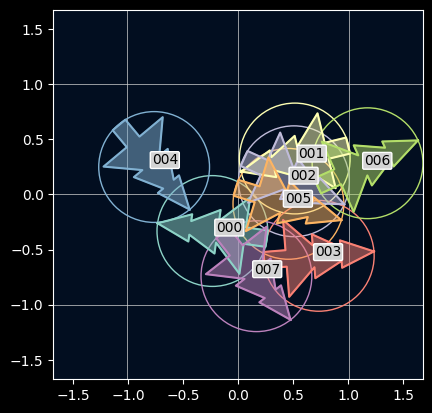

In [8]:
N_MAX = 4
N_MIN_NEIGHBOURHOOD = 1
mask = (grid.ij2n <= N_MAX) & (sum_3x3(grid.ij2n) >= N_MIN_NEIGHBOURHOOD)
print(mask.shape)

tree_packing.plot.plot_solution(
    solution,
    show_text=True,
    show_grid=True,
    show_center_circle=True,
    grid_mask=mask
)

In [9]:
triangles = solution.solution.trees.reshape(-1, 3, 2)
normals = jax.vmap(intersection._edge_normals)(triangles)
c = jnp.sum(triangles * normals, -1)

# Single Tree

In [10]:
def build_optimizer_fn(fn, steps=100, has_aux=True, lr=1e-2):
    import optax

    value_and_grad_fn = jax.value_and_grad(fn, has_aux=has_aux)

    lr = optax.schedules.warmup_cosine_decay_schedule(
        init_value=0.01 * lr,
        peak_value=lr,
        warmup_steps=int(0.1 * steps),
        decay_steps=int(steps),
        end_value=0.0
    )
    optimizer = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adam(learning_rate=lr, b1=0.9, b2=0.95)
    )

    def optimize(params, *args):
        state = optimizer.init(params)

        def update_fn(carry, _):
            params, state = carry
            value, grads = value_and_grad_fn(params, *args)
            updates, state = optimizer.update(grads, state)
            params = optax.apply_updates(params, updates)
            return (params, state), {"params": params, "value": value}

        (params, state), history = jax.lax.scan(update_fn, (params, state), length=steps)

        return params, history

    return optimize

In [11]:
params = jnp.zeros((1, 2)), jnp.zeros((1,))
params = solution.params

p_list = (
    2.0 * jax.random.uniform(jax.random.PRNGKey(42), (1_000, 2), minval=-1, maxval=+1),
    1.0 * jax.random.uniform(jax.random.PRNGKey(42), (1_000,), minval=-jnp.pi, maxval=+jnp.pi),
)

n = 401
xi = jnp.linspace(-1.5, +1.5, n)
yi = jnp.linspace(-1.5, +1.5, n)
X, Y = jnp.meshgrid(xi, yi)
pos_mesh = jnp.stack((X, Y), -1).reshape(-1, 2)

p_mesh = (
    pos_mesh,
    0 * pos_mesh[:, 0],
)

In [12]:
def feasibility_fn(p, params):
    new_tree = tree.params_to_tree(p)
    old_trees = tree.params_to_trees(params)
    old_trees = jnp.reshape(old_trees, (old_trees.shape[0] * old_trees.shape[1],) + old_trees.shape[2:])
    score = intersection.figure_intersection_score(new_tree, old_trees)
    return score


# closeness
def triangles_intersection_scores(t0, t1, n0=None, n1=None, eps=1e-12):
    """
    Strict triangle intersection score:
    - positive when triangles overlap,
    - <= 0 when separated or only touching.
    """
    if n0 is None:
        n0 = intersection._edge_normals(t0)
    if n1 is None:
        n1 = intersection._edge_normals(t1)

    axes = jnp.concatenate([n0, n1], axis=0)  # (6, 2)

    proj0 = t0 @ axes.T
    proj1 = t1 @ axes.T

    min0 = proj0.min(axis=0)
    max0 = proj0.max(axis=0)
    min1 = proj1.min(axis=0)
    max1 = proj1.max(axis=0)

    score = (max0 - min1 - eps) * (max1 - min0 - eps)
    return score


def figure_intersection_scores(f0, f1):
    fn = triangles_intersection_scores
    fn = jax.vmap(fn, (0, None))
    fn = jax.vmap(fn, (None, 0))
    return fn(f0, f1)

In [13]:
def build_score_fn(agg="min", ftol=1e-6):
    def closeness_fn(p, params):
        new_tree = tree.params_to_tree(p)
        old_trees = tree.params_to_trees(params)
        old_trees = jnp.reshape(old_trees, (old_trees.shape[0] * old_trees.shape[1],) + old_trees.shape[2:])
        #
        score = figure_intersection_scores(new_tree, old_trees)
        if agg == "min":
            score = jnp.min(score, -1)
            score = jax.nn.relu(-score)
        elif agg == "mean":
            score = jax.nn.relu(-score)
            score = jnp.mean(score, -1)
        else:
            raise ValueError(f"Unknown aggregation method {agg}")

        # what to do with scores?
        score = jax.nn.relu(score) + 1e-6
        score = score ** 0.5
        # score = jnp.log(1 + score)
        score = jnp.sum(score)
        return score

    def score_fn(p, params):
        fscore = feasibility_fn(p, params)
        cscore = closeness_fn(p, params)

        penalty = 0.0
        penalty += 1e6 * jnp.clip(fscore, ftol, jnp.inf)
        penalty += 1.0 * jnp.clip(fscore, 0, ftol)

        return penalty + cscore, (cscore, fscore)

    return score_fn

In [ ]:
score_fn = build_score_fn(agg="mean")

p_list = (
    2.0 * jax.random.uniform(jax.random.PRNGKey(42), (100_000, 2), minval=-1, maxval=+1),
    1.0 * jax.random.uniform(jax.random.PRNGKey(42), (100_000,), minval=-jnp.pi, maxval=+jnp.pi),
)
p_list_eval, _ = jax.vmap(score_fn, (0, None))(p_list, params)
idx = jnp.argsort(p_list_eval)[:256]
p_list = jax.tree.map(lambda p: p[idx], p_list)

opt_fn = jax.jit(jax.vmap(build_optimizer_fn(
    score_fn,
    lr=0.02,
    steps=1_000,
    has_aux=True
), (0, None)))

p_list_opt, p_list_opt_hist = opt_fn(p_list, params)

c_scores, f_scores = p_list_opt_hist["value"][1]
plt.plot(((f_scores < 1.) * c_scores)[f_scores[:, -1] < 0.01, :].T);

print("%.6f" % jnp.min(jnp.where(f_scores < 1e-5, c_scores, jnp.inf)[:, -1]))

In [ ]:
fig, ax = plt.subplots()

# ax.scatter(*p_list_opt[0].T)
for i in range(100):
    pi = jax.tree.map(lambda p: p[i], p_list_opt)
    tree_packing.plot.plot_tree(pi, ax=ax, color="tab:green", alpha=0.1)

best_idx = jnp.argsort(jnp.where(f_scores < 1e-5, c_scores, jnp.inf)[:, -1])

for i in best_idx[:8]:
    tree_packing.plot.plot_tree(jax.tree.map(lambda p: p[int(i)], p_list_opt), ax=ax, color="tab:red")
tree_packing.plot.plot_solution(solution, ax=ax)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from tqdm import tqdm

# If plot(i) draws on the current axes, make it accept an ax to be clean:
# def plot(i, ax): ...

fig, ax = plt.subplots()

_range = tqdm(total=100)


def plot(t):
    _range.update(1)
    t_ = int(p_list_opt_hist["params"][0].shape[0] * t / 100)
    pi = jax.tree.map(lambda p: p[:, t_], p_list_opt_hist["params"])
    tree_packing.plot.plot_trees(pi, ax=ax, color="tab:green", alpha=0.2)
    best_idx = jnp.argsort(jnp.where(f_scores < 1e-5, c_scores, jnp.inf)[:, -1])[:8]
    pi = jax.tree.map(lambda p: p[best_idx, t_], p_list_opt_hist["params"])
    tree_packing.plot.plot_trees(pi, ax=ax, color="tab:red")

    tree_packing.plot.plot_solution(solution, ax=ax)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)


def init():
    ax.clear()
    plot(0)  # or plot(0, ax)
    return []


def update(i):
    ax.clear()
    plot(i)  # or plot(i, ax)
    return []


anim = animation.FuncAnimation(
    fig, update, init_func=init,
    frames=100, interval=50, blit=False
)

plt.close(fig)  # prevents a duplicate static plot in Jupyter
HTML(anim.to_jshtml())  # inline animation